# The Laplace Problem

In [1]:
%reset -f

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

import numpy as np
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')           ## CPU is faster here !

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks',
        font='sans-serif', font_scale=1, color_codes=True, rc={"lines.linewidth": 2})

from updec.operators import *
from updec.utils import print_line_by_line, polyharmonic, multiquadric

## Using Updec

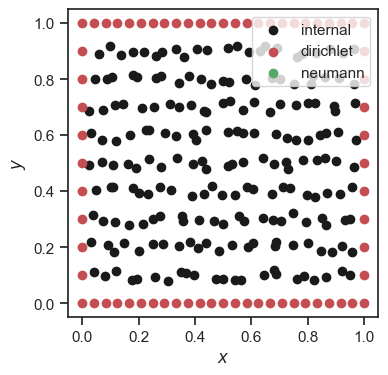

In [3]:
RBF = polyharmonic      ## Can define which rbf to use
MAX_DEGREE = 4

facet_types={0:"d", 1:"d", 2:"d", 3:"d"}
cloud = Cloud(Nx=25, Ny=11, facet_types=facet_types, noise_seed=35, support_size=1*11-1)
cloud.visualize_cloud(figsize=(4,4));

In [23]:
print("\n=== Meshfree cloud for RBF method ===\n")
print()
print("Cloud bounding box: Nx =", cloud.Nx, " -  Ny =", cloud.Ny)
print()
# print("Boundary types (0=internal, 1=dirichlet, 2=neumann):\n", cloud.node_boundary_types)
print("Number of: \n\t-Internal points: Ni =", cloud.Ni, "\n\t-Dirichlet points: Md =", cloud.Nd, "\n\t-Neumann points: Mn =", cloud.Nn)
print("Surface types:\n", cloud.facet_types)
print()
print("Global indices:\n", cloud.global_indices)
print()
# # print("Global indices reversed:\n", cloud.global_indices_rev)
# # print()
# print("Outward normals on Neumann boundaries:")
# print_line_by_line(cloud.outward_normals)
# print()
# print("Node coordinates:", )
# print_line_by_line(cloud.nodes)
# print()
# print("Local supports (closest neighbours):")
# print_line_by_line(cloud.local_supports)


=== Meshfree cloud for RBF method ===


Cloud bounding box: Nx = 25  -  Ny = 11

Number of: 
	-Internal points: Ni = 207 
	-Dirichlet points: Md = 68 
	-Neumann points: Mn = 0
Surface types:
 {0: 'd', 1: 'd', 2: 'd', 3: 'd'}

Global indices:
 [[207 208 209 210 211 212 213 214 215 216 217]
 [218   0   1   2   3   4   5   6   7   8 219]
 [220   9  10  11  12  13  14  15  16  17 221]
 [222  18  19  20  21  22  23  24  25  26 223]
 [224  27  28  29  30  31  32  33  34  35 225]
 [226  36  37  38  39  40  41  42  43  44 227]
 [228  45  46  47  48  49  50  51  52  53 229]
 [230  54  55  56  57  58  59  60  61  62 231]
 [232  63  64  65  66  67  68  69  70  71 233]
 [234  72  73  74  75  76  77  78  79  80 235]
 [236  81  82  83  84  85  86  87  88  89 237]
 [238  90  91  92  93  94  95  96  97  98 239]
 [240  99 100 101 102 103 104 105 106 107 241]
 [242 108 109 110 111 112 113 114 115 116 243]
 [244 117 118 119 120 121 122 123 124 125 245]
 [246 126 127 128 129 130 131 132 133 134 247]
 [24

In [5]:
## Operates on radial basis functions and polynomials at position x: don't forget the None. It is important!
# @jax.jit
# @partial(jax.jit, static_argnums=2)
def my_diff_operator(x, node=None, monomial=None):
    return  -1 * nodal_laplacian(x, node, monomial, rbf=RBF)

known_field = jnp.ones((cloud.N, 2))
## Operates on entire fields at position x (inside node)
# @jax.jit
def my_rhs_operator(x):
    # return divergence(x, known_field, cloud, rbf=RBF, max_degree=2)
    # return 2.0
    return 0.0

# d_func = lambda node: 1.0
# n_func = lambda node: 1.0

d_north = lambda node: jnp.sin(jnp.pi * node[0])
d_zero = lambda node: 0.0

boundary_conditions = {0:d_zero, 1:d_zero, 2:d_north, 3:d_zero}

In [6]:
solution_field = pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)
# unknown_field

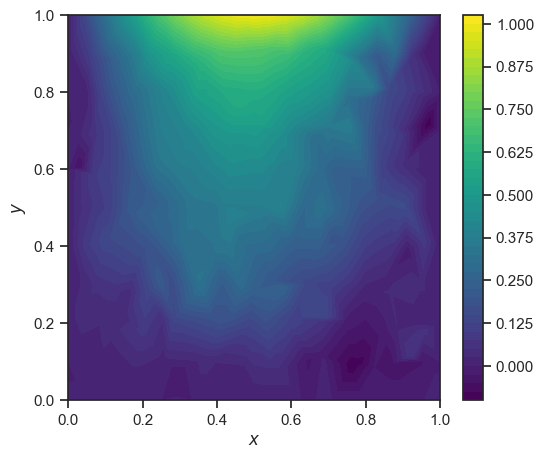

In [22]:
# cloud.visualize_field(solution_field, cmap="jet", projection="3d", ax=None, figsize=(10,10));
cloud.visualize_field(solution_field, cmap="viridis", projection="2d", ax=None, figsize=(6,5));

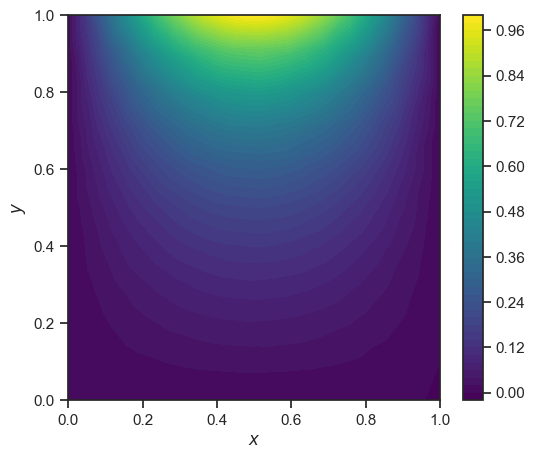

In [12]:
## Exact solution
sorted_nodes = sorted(cloud.nodes.items(), key=lambda x:x[0])
coords = jnp.stack(list(dict(sorted_nodes).values()), axis=-1).T

# exact_sol = jnp.zeros((cloud.N), dtype=jnp.float32)
def laplace_exact_sol(coord):
    return jnp.sin(jnp.pi*coord[0])*jnp.sinh(jnp.pi*coord[1]) / jnp.sinh(jnp.pi)

laplace_exact_sol = jax.vmap(laplace_exact_sol, in_axes=(0,), out_axes=0)

exact_sol = laplace_exact_sol(coords)

# cloud.visualize_field(exact_sol, cmap="jet", projection="3d", ax=None, figsize=(10,10));
ax, img = cloud.visualize_field(exact_sol, cmap="viridis", projection="2d", ax=None, figsize=(6,5), levels=50);

Error: 1.626405


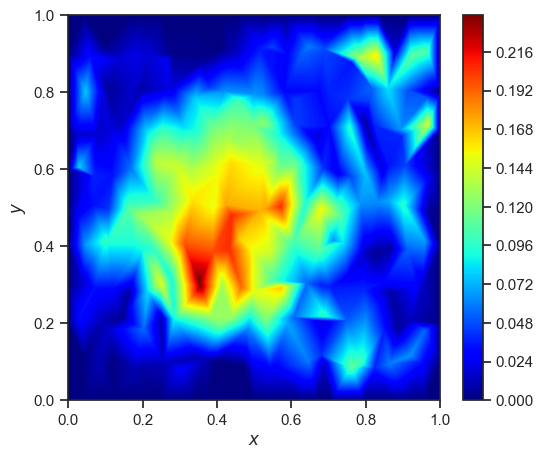

In [21]:
error = jnp.abs(exact_sol-solution_field)
print("Error:", jnp.sum(error**2))
# cloud.visualize_field(error, cmap="jet", projection="3d", ax=None, figsize=(10,10));
cloud.visualize_field(error, cmap="jet", projection="2d", ax=None, figsize=(6,5), levels=400);

## Code profiling

In [10]:
# ### Profiling the code
# import cProfile
# cloud = Cloud(Nx=11, Ny=7, facet_types=facet_types, noise_seed=34)
# cProfile.run('pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)', filename=None, sort=2)